100%|██████████| 170498071/170498071 [00:03<00:00, 49569259.80it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Epoch 1/30 - Train Loss: 2.0250, Train Accuracy: 0.3291, Val Loss: 1.9801, Val Accuracy: 0.4128, Time: 93.05 seconds
Epoch 2/30 - Train Loss: 1.7595, Train Accuracy: 0.4038, Val Loss: 1.9218, Val Accuracy: 0.4468, Time: 77.56 seconds
Epoch 3/30 - Train Loss: 1.6695, Train Accuracy: 0.4303, Val Loss: 1.8727, Val Accuracy: 0.4689, Time: 78.74 seconds
Epoch 4/30 - Train Loss: 1.6113, Train Accuracy: 0.4498, Val Loss: 1.8664, Val Accuracy: 0.4688, Time: 77.65 seconds
Epoch 5/30 - Train Loss: 1.5651, Train Accuracy: 0.4672, Val Loss: 1.8538, Val Accuracy: 0.4728, Time: 79.50 seconds
Epoch 6/30 - Train Loss: 1.5327, Train Accuracy: 0.4768, Val Loss: 1.8014, Val Accuracy: 0.4843, Time: 82.64 seconds
Epoch 7/30 - Train Loss: 1.4999, Train Accuracy: 0.4902, Val Loss: 1.8073, Val Accuracy: 0.4995, Time: 79.08 seconds
Epoch 8/30 - Train Loss: 1.4724, Train Accuracy: 0.4987, Val Loss: 1.7537, Val Accuracy: 0.4975,

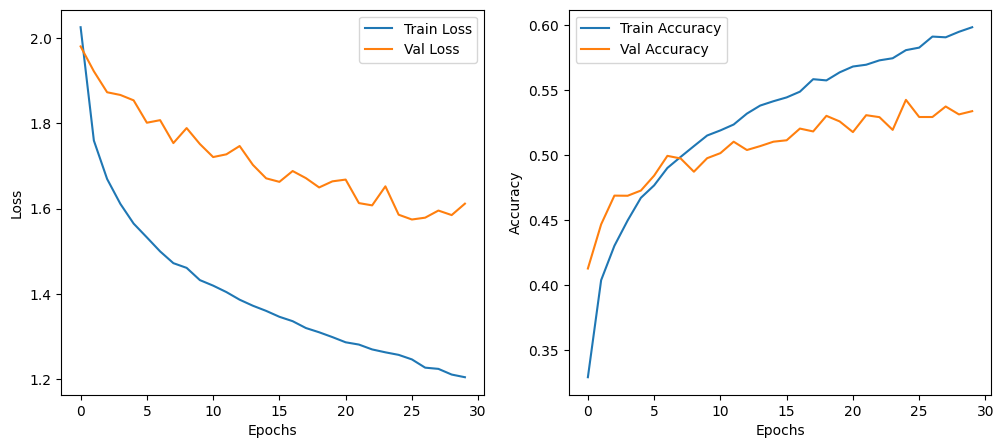

Test Accuracy: 0.5336


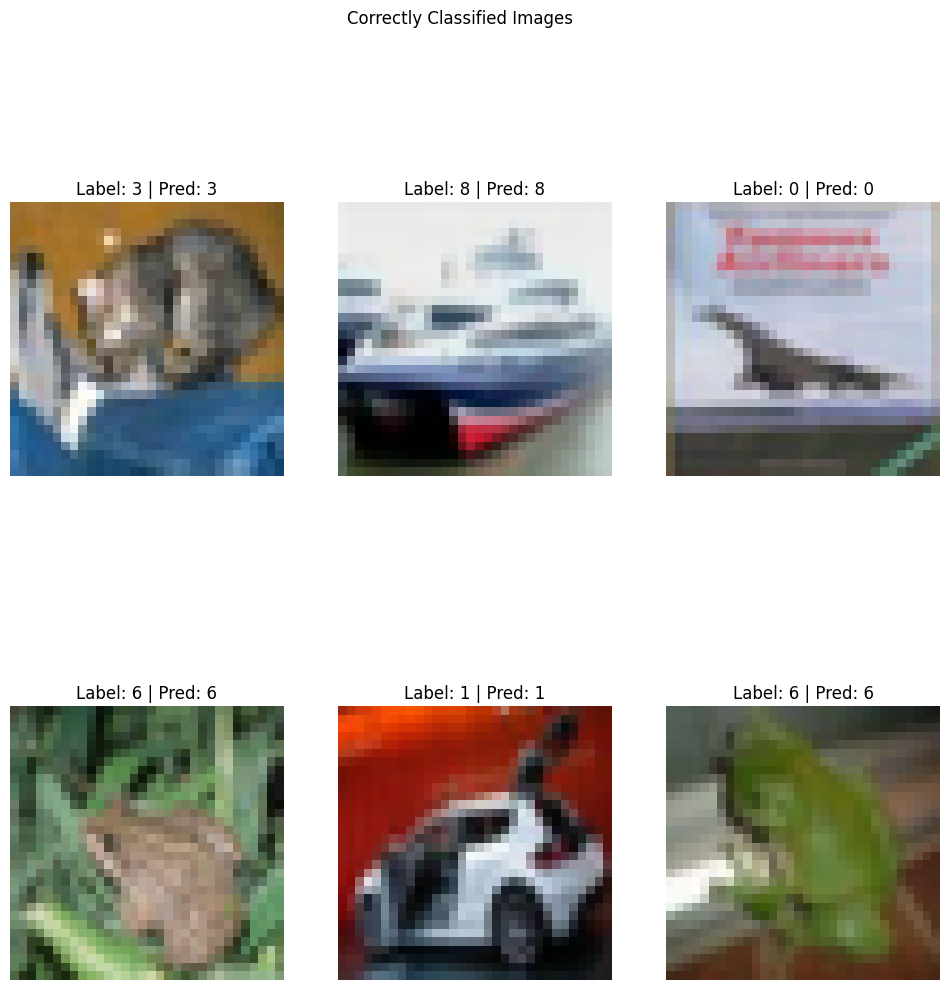

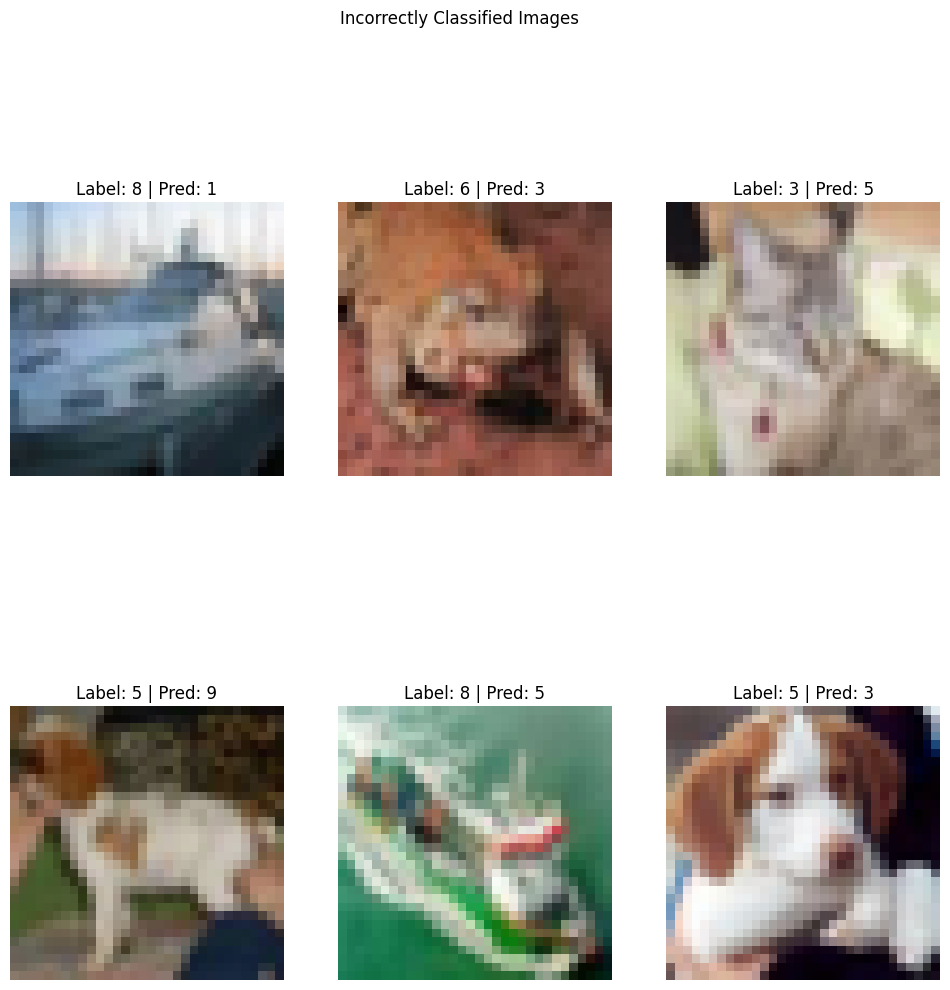

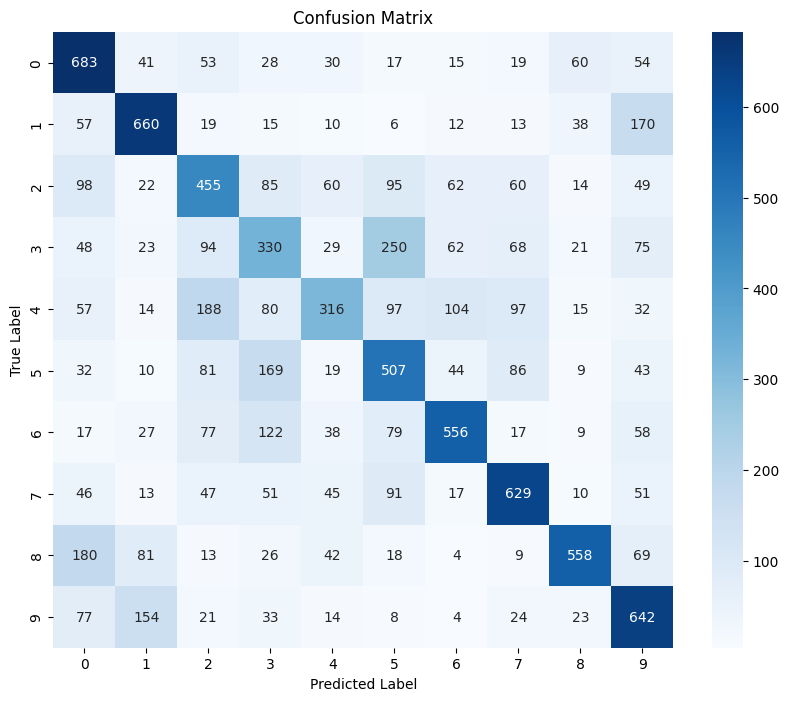

              precision    recall  f1-score   support

    airplane       0.53      0.68      0.60      1000
  automobile       0.63      0.66      0.65      1000
        bird       0.43      0.46      0.44      1000
         cat       0.35      0.33      0.34      1000
        deer       0.52      0.32      0.39      1000
         dog       0.43      0.51      0.47      1000
        frog       0.63      0.56      0.59      1000
       horse       0.62      0.63      0.62      1000
        ship       0.74      0.56      0.64      1000
       truck       0.52      0.64      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.53      0.53     10000



In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from torchvision import datasets, transforms

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

# Load CIFAR-10 dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]),
}

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=data_transforms['train'])
val_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=data_transforms['val'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

n_classes = 10  # CIFAR-10 has 10 classes

# Define the VIB model (DeepVIB)
class DeepVIB(nn.Module):
    def __init__(self, input_shape, output_shape, z_dim):
        super(DeepVIB, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.z_dim = z_dim

        # Build encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True)
        )
        self.fc_mu = nn.Linear(1024, self.z_dim)
        self.fc_std = nn.Linear(1024, self.z_dim)

        # Build decoder
        self.decoder = nn.Linear(self.z_dim, output_shape)

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), F.softplus(self.fc_std(x) - 5, beta=1)

    def decode(self, z):
        return self.decoder(z)

    def reparameterise(self, mu, std):
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        mu, std = self.encode(x_flat)
        z = self.reparameterise(mu, std)
        return self.decode(z), mu, std


# Hyperparameters
beta = 1e-3
z_dim = 256
epochs = 30
learning_rate = 1e-4
decay_rate = 0.97

# Initialize the model, optimizer, and learning rate scheduler
input_shape = 32 * 32 * 3  # CIFAR-10 image size is 32x32 with 3 color channels (RGB)
vib = DeepVIB(input_shape, n_classes, z_dim).to(device)
optimizer = torch.optim.Adam(vib.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

# Loss function: Cross Entropy Loss (CE) + beta*KL divergence
def loss_function(y_pred, y, mu, std):
    CE = F.cross_entropy(y_pred, y, reduction='sum')
    KL = 0.5 * torch.sum(mu.pow(2) + std.pow(2) - 2 * std.log() - 1)
    return (beta * KL + CE) / y.size(0)

# Training loop
train_measures = defaultdict(list)
val_measures = defaultdict(list)
start_time = time.time()

for epoch in range(epochs):
    vib.train()
    epoch_start_time = time.time()

    train_loss = 0
    train_accuracy = 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        vib.zero_grad()
        y_pred, mu, std = vib(X)
        loss = loss_function(y_pred, y, mu, std)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)
        y_pred_labels = torch.argmax(y_pred, dim=1)
        train_accuracy += (y_pred_labels == y).sum().item()

    train_measures['loss'].append(train_loss / len(train_dataloader.dataset))
    train_measures['accuracy'].append(train_accuracy / len(train_dataloader.dataset))

    # Validation loop
    vib.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            y_pred, mu, std = vib(X)
            loss = loss_function(y_pred, y, mu, std)
            val_loss += loss.item() * X.size(0)
            y_pred_labels = torch.argmax(y_pred, dim=1)
            val_accuracy += (y_pred_labels == y).sum().item()

    val_measures['loss'].append(val_loss / len(val_dataloader.dataset))
    val_measures['accuracy'].append(val_accuracy / len(val_dataloader.dataset))

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {train_measures['loss'][-1]:.4f}, "
          f"Train Accuracy: {train_measures['accuracy'][-1]:.4f}, "
          f"Val Loss: {val_measures['loss'][-1]:.4f}, "
          f"Val Accuracy: {val_measures['accuracy'][-1]:.4f}, "
          f"Time: {time.time() - epoch_start_time:.2f} seconds")

# Plotting the training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_measures['loss'], label='Train Loss')
plt.plot(val_measures['loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_measures['accuracy'], label='Train Accuracy')
plt.plot(val_measures['accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Testing the model
vib.eval()
test_accuracy = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred, mu, std = vib(X)
        y_pred_labels = torch.argmax(y_pred, dim=1)
        test_accuracy += (y_pred_labels == y).sum().item()
        all_preds.append(y_pred_labels.cpu().numpy())
        all_labels.append(y.cpu().numpy())

test_accuracy /= len(val_dataloader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Visualizing correctly classified images
correct_indices = np.where(all_preds == all_labels)[0]
incorrect_indices = np.where(all_preds != all_labels)[0]

def visualize_images(indices, title):
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices[:6]):
        img, label = val_dataset[idx]
        img = img.permute(1, 2, 0)  # Reshape for plotting
        img = img.numpy()
        img = img * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])  # Unnormalize
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label} | Pred: {all_preds[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display correct and incorrect classifications
visualize_images(correct_indices, "Correctly Classified Images")
visualize_images(incorrect_indices, "Incorrectly Classified Images")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))